# Goal - We have sales data from 2005 to 2016. Using this we have to forecast sales for the next 2 years i.e 2017 & 2018

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import plotly.offline as pyoff
import plotly.graph_objs as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_path='/content/gdrive/MyDrive/data-files/Sales Forecasting_Train Data.csv'
df = pd.read_csv(root_path)

In [ ]:
df.shape

(17536, 8)

In [ ]:
df.head()

,HQ,Country,State_of_outlet,City_of_outlet,Month,Day,Year,Total_Sales
0,Asia,India,NaN,Bombay (Mumbai),1,1,2005,72.2
1,Asia,India,NaN,Bombay (Mumbai),1,2,2005,72.7
2,Asia,India,NaN,Bombay (Mumbai),1,3,2005,74.3
3,Asia,India,NaN,Bombay (Mumbai),1,4,2005,78.9
4,Asia,India,NaN,Bombay (Mumbai),1,5,2005,81.5


In [ ]:
df['State_of_outlet'].unique()

array([nan])

In [ ]:
df['State_of_outlet'].value_counts()

Series([], Name: State_of_outlet, dtype: int64)

**Since State_of_outlet column is empty we shall drop the column**

In [ ]:
df.drop(columns=['State_of_outlet'], inplace=True)

Checking for null values

In [ ]:
df.isnull().sum().sort_values(ascending=False)

Total_Sales       0
Year              0
Day               0
Month             0
City_of_outlet    0
Country           0
HQ                0
dtype: int64

In [ ]:
df.describe()

,Month,Day,Year,Total_Sales
count,17536.000000,17536.000000,17536.000000,17536.000000
mean,6.524179,15.732892,2010.502053,80.117963
std,3.449400,8.801978,3.452525,13.315486
min,1.000000,1.000000,2005.000000,-99.000000
25%,4.000000,8.000000,2008.000000,77.500000
50%,7.000000,16.000000,2011.000000,82.600000
75%,10.000000,23.000000,2014.000000,86.100000
max,12.000000,31.000000,2016.000000,102.500000


Analysis:
- there are negative sales also 
- max sales is 102
- mean sales is 82

In [ ]:
df.describe(include='object')

,HQ,Country,City_of_outlet
count,17536,17536,17536
unique,1,1,4
top,Asia,India,Calcutta
freq,17536,17536,4384


There are 4 regions. lets analyse the no of sales in each region

In [ ]:
df['City_of_outlet'].value_counts()

Calcutta            4384
Chennai (Madras)    4384
Bombay (Mumbai)     4384
Delhi               4384
Name: City_of_outlet, dtype: int64

We will create a datetime format so that we can sort the data

In [ ]:
df['Date']=pd.to_datetime(df[['Year','Month','Day']])

In [ ]:
df.sort_values(by=['Date'], inplace =True)
df

,HQ,Country,City_of_outlet,Month,Day,Year,Total_Sales,Date
0,Asia,India,Bombay (Mumbai),1,1,2005,72.2,2005-01-01
730,Asia,India,Chennai (Madras),1,1,2005,75.8,2005-01-01
1095,Asia,India,Delhi,1,1,2005,61.0,2005-01-01
365,Asia,India,Calcutta,1,1,2005,66.5,2005-01-01
1,Asia,India,Bombay (Mumbai),1,2,2005,72.7,2005-01-02
...,...,...,...,...,...,...,...,...
16802,Asia,India,Calcutta,12,30,2016,67.4,2016-12-30
17169,Asia,India,Chennai (Madras),12,31,2016,76.8,2016-12-31
16437,Asia,India,Bombay (Mumbai),12,31,2016,79.7,2016-12-31
16803,Asia,India,Calcutta,12,31,2016,67.1,2016-12-31


Each region has sales for each dates

**Lets see the sales graph to understand if it has a pattern**

In [ ]:
plot_data = [
    go.Scatter(
        x=df['Date'],
        y=df['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.update_layout(yaxis_range=[45,100])
pyoff.iplot(fig)

looks like the sales are seasonal. at the start of the year sales seems low & gradually improves.
Sales is highest around June-July and again the sales declines

**Lets check the sum of tatal sales for each year**

In [ ]:
df_grouped_year = pd.DataFrame(df.groupby(['Year'])['Total_Sales'].sum().reset_index())

In [ ]:
plot_data = [
    go.Scatter(
        x=df_grouped_year['Year'],
        y=df_grouped_year['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.update_layout(yaxis_range=[45,100])
pyoff.iplot(fig)

sales was lowest in the year 2007 & highest in the year 2016

# **We will analyse the sales region wise & all regions combined too**
So we ll do 5 analysis

1.   for all regions
2.   for Mumbai
3.   for Chennai
4.   for Delhi
5.   for Calcutta 

lets segregate the data into its regions

In [ ]:
df_Mumbai = df[df['City_of_outlet']=='Bombay (Mumbai)']
df_Chennai = df[df['City_of_outlet']=='Chennai (Madras)']
df_Delhi = df[df['City_of_outlet']=='Delhi']
df_Calcutta = df[df['City_of_outlet']=='Calcutta']

Lets start forecasting with **All regions**

In [ ]:
df_all_r= df.drop(columns=['HQ', 'Country', 'City_of_outlet', 'Month', 'Day', 'Year'])
df_all_r

,Total_Sales,Date
0,72.2,2005-01-01
730,75.8,2005-01-01
1095,61.0,2005-01-01
365,66.5,2005-01-01
1,72.7,2005-01-02
...,...,...
16802,67.4,2016-12-30
17169,76.8,2016-12-31
16437,79.7,2016-12-31
16803,67.1,2016-12-31


In [ ]:
df_all_r['Date'] = pd.to_datetime(df_all_r['Date'],format='%Y%m%d')
df_all_r['Year'] = pd.DatetimeIndex(df_all_r['Date']).year
df_all_r['Month'] = pd.DatetimeIndex(df_all_r['Date']).month

In [ ]:
df_all_r["Period"] = df_all_r["Year"].astype(str) +"-" +df_all_r["Month"].astype(str)
df_all_r

,Total_Sales,Date,Year,Month,Period
0,72.2,2005-01-01,2005,1,2005-1
730,75.8,2005-01-01,2005,1,2005-1
1095,61.0,2005-01-01,2005,1,2005-1
365,66.5,2005-01-01,2005,1,2005-1
1,72.7,2005-01-02,2005,1,2005-1
...,...,...,...,...,...
16802,67.4,2016-12-30,2016,12,2016-12
17169,76.8,2016-12-31,2016,12,2016-12
16437,79.7,2016-12-31,2016,12,2016-12
16803,67.1,2016-12-31,2016,12,2016-12


In [ ]:
df_all_r = df_all_r.groupby('Period').Total_Sales.sum().reset_index()
df_all_r['Period'] = pd.to_datetime(df_all_r['Period'],format='%Y-%m')
df_all_r.sort_values(by=['Period'], inplace =True)
df_all_r

,Period,Total_Sales
0,2005-01-01,8549.0
4,2005-02-01,8286.8
5,2005-03-01,9886.5
6,2005-04-01,10061.3
7,2005-05-01,10850.0
...,...,...
142,2016-08-01,10604.5
143,2016-09-01,9991.5
133,2016-10-01,10349.6
134,2016-11-01,8603.7


**Plotting sales of all regions w.r.t. years**

In [ ]:
plot_data = [
    go.Scatter(
        x=df_all_r['Period'],
        y=df_all_r['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.update_layout(yaxis_range=[45,100])
pyoff.iplot(fig)

we can say sales are having some seasonality

In [ ]:
df_all_r.set_index('Period', inplace=True)
df_all_r

,Total_Sales
Period,
2005-01-01,8549.0
2005-02-01,8286.8
2005-03-01,9886.5
2005-04-01,10061.3
2005-05-01,10850.0
...,...
2016-08-01,10604.5
2016-09-01,9991.5
2016-10-01,10349.6


**Using minmax scaler to scale the data to be between 0 and 1**

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df_all_r_scaled = scaler.fit_transform(np.array(df_all_r).reshape(-1,1))

**Splitting training & test into 75:25 ratio**

In [ ]:
training_size = int(len(df_all_r_scaled)*0.75)
test_size = len(df_all_r_scaled)-training_size
train_data, test_data = df_all_r_scaled[0:training_size,:], df_all_r_scaled[training_size:len(df_all_r_scaled)+1,:1]

In [ ]:
training_size,test_size

(108, 36)

Creating a matrix to train on a certain no of data and predict an output in recursion
EG:


ip: 5, 10, 15, 20     op: 25


ip: 10, 15, 20, 25    op: 30

ip: 15, 20, 25, 30    op: 35

we will take a window of 12 for prediction

In [ ]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, y_train.shape

((95, 12), (95,))

In [ ]:
X_test.shape, y_test.shape

((23, 12), (23,))

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(95, 12, 1)
(23, 12, 1)


**Model Building**

In [ ]:
model=Sequential()
model.add(LSTM(512,return_sequences=True,input_shape=(12,1)))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer='adam')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 512)           1052672   
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 256)           787456    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,037,377
Trainable params: 2,037,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
all_r_history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=50, batch_size=60, verbose=1 ,shuffle=False)

Epoch 1/50
2/2 [==============================] - 8s 2s/step - loss: 0.5318 - val_loss: 0.2084
Epoch 2/50
2/2 [==============================] - 1s 466ms/step - loss: 0.3423 - val_loss: 0.2100
Epoch 3/50
2/2 [==============================] - 1s 454ms/step - loss: 0.2219 - val_loss: 0.3202
Epoch 4/50
2/2 [==============================] - 1s 447ms/step - loss: 0.3024 - val_loss: 0.3241
Epoch 5/50
2/2 [==============================] - 1s 457ms/step - loss: 0.2900 - val_loss: 0.2589
Epoch 6/50
2/2 [==============================] - 1s 445ms/step - loss: 0.2221 - val_loss: 0.2021
Epoch 7/50
2/2 [==============================] - 1s 474ms/step - loss: 0.2115 - val_loss: 0.2074
Epoch 8/50
2/2 [==============================] - 1s 447ms/step - loss: 0.2068 - val_loss: 0.2149
Epoch 9/50
2/2 [==============================] - 1s 479ms/step - loss: 0.2029 - val_loss: 0.2364
Epoch 10/50
2/2 [==============================] - 1s 464ms/step - loss: 0.2169 - val_loss: 0.2284
Epoch 11/50
2/2 [=====

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
import math
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train,train_predict)

0.11788048848874136

In [ ]:
mean_absolute_error(y_test,test_predict)

0.1262443383238789

Inverse Transform predictions - It will prepare the transform of the target variable using the same training data used to fit the model, then apply that inverse transform on the data provided when calling predict(), returning predictions in the correct scale.

In [ ]:
inv_train_predict=scaler.inverse_transform(train_predict)
inv_test_predict=scaler.inverse_transform(test_predict)

In [ ]:
mean_absolute_error(y_train,inv_train_predict)

9434.25144822117

In [ ]:
mean_absolute_error(y_test,inv_test_predict)

9445.898958211015

We can expect an error of 9445.89 in our predictions

**Plotting Loss**

In [ ]:
def plot_accuracy_loss(history):
  plt.plot(history.history['loss'], 'bo--', label = "loss")
  plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
  plt.ylabel("loss")
  plt.xlabel("epochs")
  
  plt.legend()
  plt.show()

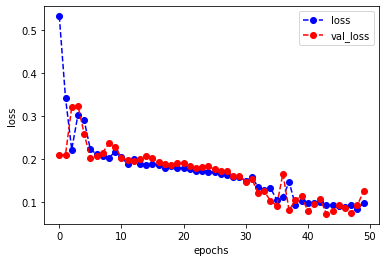

In [ ]:
plot_accuracy_loss(all_r_history)

**Plotting Train & test predictions**We can expect an error of 9445.89 in our predictionsWe can expect an error of 9445.89 in our predictionsWe can expect an error of 9445.89 in our predictionsweWWwhW
   

In [ ]:
look_back=12
trainPredictPlot = np.empty_like(df_all_r_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = inv_train_predict

In [ ]:
testPredictPlot = np.empty_like(df_all_r)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_all_r_scaled)-1, :] = inv_test_predict

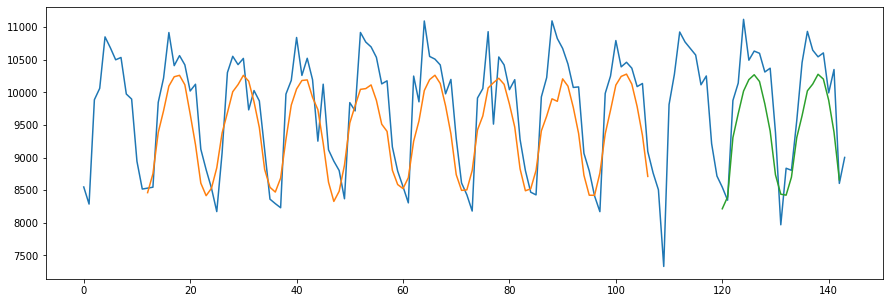

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(df_all_r_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
# plt.ylim(200, 400)

plt.show()

In [ ]:
len(test_data)

36

In [ ]:
x_input=test_data[36-12:].reshape(1,-1)
x_input.shape

(1, 12)

In [ ]:
temp_input=list(x_input)
temp_input

[array([0.3974606 , 0.38906634, 0.59039675, 0.82543621, 0.95124462,
        0.87530027, 0.84837526, 0.8642399 , 0.70242589, 0.79695378,
        0.33608743, 0.44117414])]

In [ ]:
temp_input=temp_input[0].tolist()

**Predicting Sales for All regions for the next 24 months**

In [ ]:
# demonstrate prediction for next 24 months
from numpy import array

lst_output=[]
n_steps=12
i=0
while(i<25):
    
    if(len(temp_input)>12):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} month >100 input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} month >100 output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

# print(lst_output)

1 month >100 input [0.38906634 0.59039675 0.82543621 0.95124462 0.87530027 0.84837526
 0.8642399  0.70242589 0.79695378 0.33608743 0.44117414 0.33712745]
1 month >100 output [[0.40073597]]
2 month >100 input [0.59039675 0.82543621 0.95124462 0.87530027 0.84837526 0.8642399
 0.70242589 0.79695378 0.33608743 0.44117414 0.33712745 0.40073597]
2 month >100 output [[0.5268238]]
3 month >100 input [0.82543621 0.95124462 0.87530027 0.84837526 0.8642399  0.70242589
 0.79695378 0.33608743 0.44117414 0.33712745 0.40073597 0.52682382]
3 month >100 output [[0.63985]]
4 month >100 input [0.95124462 0.87530027 0.84837526 0.8642399  0.70242589 0.79695378
 0.33608743 0.44117414 0.33712745 0.40073597 0.52682382 0.63985002]
4 month >100 output [[0.7123884]]
5 month >100 input [0.87530027 0.84837526 0.8642399  0.70242589 0.79695378 0.33608743
 0.44117414 0.33712745 0.40073597 0.52682382 0.63985002 0.7123884 ]
5 month >100 output [[0.74265975]]
6 month >100 input [0.84837526 0.8642399  0.70242589 0.796953

In [ ]:
month_new=np.arange(1,61)
month_pred=np.arange(60,85)

In [ ]:
month_new.shape

(60,)

In [ ]:
month_pred.shape

(25,)

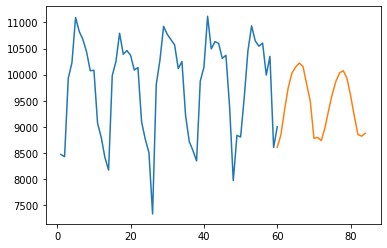

In [ ]:
plt.plot(month_new,scaler.inverse_transform(df_all_r_scaled[len(df_all_r_scaled)-60:]))
plt.plot(month_pred,scaler.inverse_transform(lst_output))

Prediction for all region says for 2017 the sales would range between 8700 to 10200

# **Lets check region wise seperately**

**For Mumbai**


In [ ]:
df_Mumbai = df_Mumbai.drop(columns=['HQ', 'Country', 'City_of_outlet', 'Month', 'Day', 'Year'])
df_Mumbai

,Total_Sales,Date
0,72.2,2005-01-01
1,72.7,2005-01-02
2,74.3,2005-01-03
3,78.9,2005-01-04
4,81.5,2005-01-05
...,...,...
16433,79.8,2016-12-27
16434,79.9,2016-12-28
16435,80.6,2016-12-29
16436,81.1,2016-12-30


In [ ]:
df_Mumbai['Date'] = pd.to_datetime(df_Mumbai['Date'],format='%Y%m%d')
df_Mumbai['Year'] = pd.DatetimeIndex(df_Mumbai['Date']).year
df_Mumbai['Month'] = pd.DatetimeIndex(df_Mumbai['Date']).month

In [ ]:
df_Mumbai["Period"] = df_Mumbai["Year"].astype(str) +"-" +df_Mumbai["Month"].astype(str)
df_Mumbai

,Total_Sales,Date,Year,Month,Period
0,72.2,2005-01-01,2005,1,2005-1
1,72.7,2005-01-02,2005,1,2005-1
2,74.3,2005-01-03,2005,1,2005-1
3,78.9,2005-01-04,2005,1,2005-1
4,81.5,2005-01-05,2005,1,2005-1
...,...,...,...,...,...
16433,79.8,2016-12-27,2016,12,2016-12
16434,79.9,2016-12-28,2016,12,2016-12
16435,80.6,2016-12-29,2016,12,2016-12
16436,81.1,2016-12-30,2016,12,2016-12


In [ ]:
df_Mumbai = df_Mumbai.groupby('Period').Total_Sales.sum().reset_index()
df_Mumbai['Period'] = pd.to_datetime(df_Mumbai['Period'],format='%Y-%m')
df_Mumbai.sort_values(by=['Period'], inplace =True)
df_Mumbai

,Period,Total_Sales
0,2005-01-01,2351.4
4,2005-02-01,2245.5
5,2005-03-01,2504.3
6,2005-04-01,2527.1
7,2005-05-01,2643.6
...,...,...
142,2016-08-01,2549.0
143,2016-09-01,2446.4
133,2016-10-01,2581.3
134,2016-11-01,2313.7


**Plotting graph of Mumbai sales**

In [ ]:
plot_data = [
    go.Scatter(
        x=df_Mumbai['Period'],
        y=df_Mumbai['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.update_layout(yaxis_range=[45,100])
pyoff.iplot(fig)

In [ ]:
df_Mumbai.set_index('Period', inplace=True)
df_Mumbai

,Total_Sales
Period,
2005-01-01,2351.4
2005-02-01,2245.5
2005-03-01,2504.3
2005-04-01,2527.1
2005-05-01,2643.6
...,...
2016-08-01,2549.0
2016-09-01,2446.4
2016-10-01,2581.3


**Scaling data**

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
mumbai_scaled = scaler.fit_transform(np.array(df_Mumbai).reshape(-1,1))

**Spitting train & test into 70:30 ratio**

In [ ]:
training_size = int(len(mumbai_scaled)*0.70)
test_size = len(mumbai_scaled)-training_size
train_data, test_data = mumbai_scaled[0:training_size,:], mumbai_scaled[training_size:len(mumbai_scaled)+1,:1]

In [ ]:
train_data.shape,test_data.shape

((100, 1), (44, 1))

**Creating a window of 12 to provide info to model to predict the label**

In [ ]:
time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, y_train.shape

((87, 12), (87,))

In [ ]:
X_test.shape, y_test.shape

((31, 12), (31,))

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(87, 12, 1)
(31, 12, 1)


**Model Building**

In [ ]:
mumbai_history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=15, batch_size=50, verbose=1)

Epoch 1/15
2/2 [==============================] - 1s 451ms/step - loss: 0.0729 - val_loss: 0.1019
Epoch 2/15
2/2 [==============================] - 1s 447ms/step - loss: 0.0737 - val_loss: 0.0977
Epoch 3/15
2/2 [==============================] - 1s 441ms/step - loss: 0.0702 - val_loss: 0.0933
Epoch 4/15
2/2 [==============================] - 1s 463ms/step - loss: 0.0713 - val_loss: 0.0953
Epoch 5/15
2/2 [==============================] - 1s 433ms/step - loss: 0.0717 - val_loss: 0.1012
Epoch 6/15
2/2 [==============================] - 1s 450ms/step - loss: 0.0730 - val_loss: 0.0936
Epoch 7/15
2/2 [==============================] - 1s 475ms/step - loss: 0.0711 - val_loss: 0.0961
Epoch 8/15
2/2 [==============================] - 1s 450ms/step - loss: 0.0734 - val_loss: 0.1069
Epoch 9/15
2/2 [==============================] - 1s 423ms/step - loss: 0.0770 - val_loss: 0.1074
Epoch 10/15
2/2 [==============================] - 1s 442ms/step - loss: 0.0741 - val_loss: 0.0948
Epoch 11/15
2/2 [==

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
mean_absolute_error(y_train,train_predict)

0.07322559254666729

In [ ]:
mean_absolute_error(y_test,test_predict)

0.09231562098548637

In [ ]:
inv_train_predict=scaler.inverse_transform(train_predict)
inv_test_predict=scaler.inverse_transform(test_predict)

In [ ]:
mean_absolute_error(y_train,inv_train_predict)

2484.1843140880746

In [ ]:
mean_absolute_error(y_test,inv_test_predict)

2527.2255071461627

We can expect an error of 2527.22 in for predictions 

**Plotting Loss**

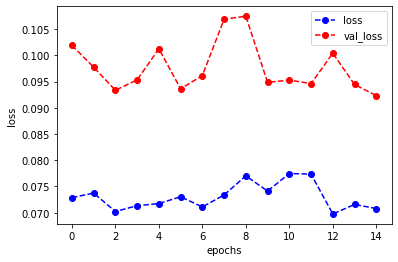

In [ ]:
plot_accuracy_loss(mumbai_history)

**Plotting train & test Predictions**

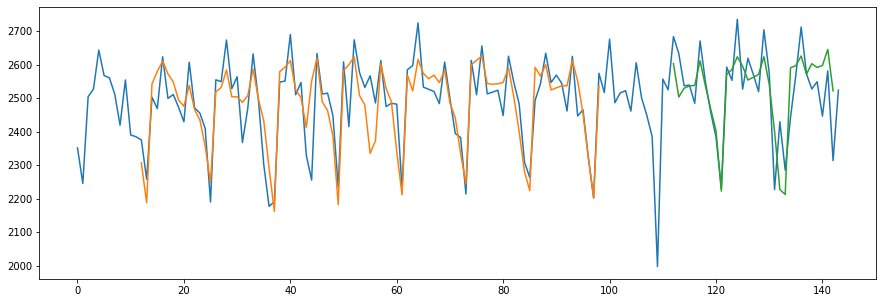

In [ ]:
look_back=12
trainPredictPlot = np.empty_like(mumbai_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = inv_train_predict

testPredictPlot = np.empty_like(df_all_r)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(mumbai_scaled)-1, :] = inv_test_predict

plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(mumbai_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [ ]:
len(test_data)

44

**Predicting Sales for Mumbai regions for the next 24 months**

In [ ]:
x_input=test_data[44-12:].reshape(1,-1)

temp_input=list(x_input)

temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=12
i=0
while(i<25):
    
    if(len(temp_input)>12):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} month >100 input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} month >100 output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

1 month >100 input [0.38999593 0.60322624 0.77456961 0.96882201 0.77931408 0.71804256
 0.74745832 0.60837739 0.79124305 0.42849397 0.71370476 0.410963  ]
1 month >100 output [[0.27393728]]
2 month >100 input [0.60322624 0.77456961 0.96882201 0.77931408 0.71804256 0.74745832
 0.60837739 0.79124305 0.42849397 0.71370476 0.410963   0.27393728]
2 month >100 output [[0.7155852]]
3 month >100 input [0.77456961 0.96882201 0.77931408 0.71804256 0.74745832 0.60837739
 0.79124305 0.42849397 0.71370476 0.410963   0.27393728 0.71558517]
3 month >100 output [[0.8248581]]
4 month >100 input [0.96882201 0.77931408 0.71804256 0.74745832 0.60837739 0.79124305
 0.42849397 0.71370476 0.410963   0.27393728 0.71558517 0.82485813]
4 month >100 output [[0.8549604]]
5 month >100 input [0.77931408 0.71804256 0.74745832 0.60837739 0.79124305 0.42849397
 0.71370476 0.410963   0.27393728 0.71558517 0.82485813 0.85496038]
5 month >100 output [[0.7773603]]
6 month >100 input [0.71804256 0.74745832 0.60837739 0.7912

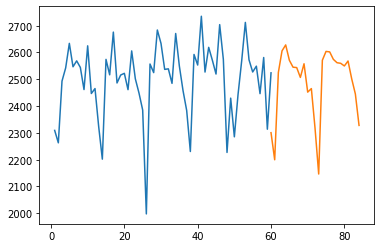

In [ ]:
month_new=np.arange(1,61)
month_pred=np.arange(60,85)

plt.plot(month_new,scaler.inverse_transform(mumbai_scaled[len(mumbai_scaled)-60:]))
plt.plot(month_pred,scaler.inverse_transform(lst_output))

Prediction for Mumbai says the sales ranges between 2200 & 2650 for the year-2017 & between 2150 to 2600 for the year-2018

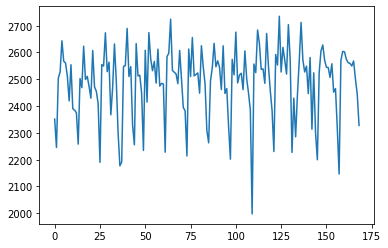

In [ ]:
df_pred=mumbai_scaled.tolist()
df_pred.extend(lst_output)
df_pred=scaler.inverse_transform(df_pred).tolist()
plt.plot(df_pred)

**For Chennai**

In [ ]:
df_Chennai = df_Chennai.drop(columns=['HQ', 'Country', 'City_of_outlet', 'Month', 'Day', 'Year'])
df_Chennai['Date'] = pd.to_datetime(df_Chennai['Date'],format='%Y%m%d')
df_Chennai['Year'] = pd.DatetimeIndex(df_Chennai['Date']).year
df_Chennai['Month'] = pd.DatetimeIndex(df_Chennai['Date']).month

df_Chennai["Period"] = df_Chennai["Year"].astype(str) +"-" +df_Chennai["Month"].astype(str)

df_Chennai = df_Chennai.groupby('Period').Total_Sales.sum().reset_index()
df_Chennai['Period'] = pd.to_datetime(df_Chennai['Period'],format='%Y-%m')
df_Chennai.sort_values(by=['Period'], inplace =True)

df_Chennai

,Period,Total_Sales
0,2005-01-01,2413.3
4,2005-02-01,2222.2
5,2005-03-01,2588.1
6,2005-04-01,2506.7
7,2005-05-01,2717.7
...,...,...
142,2016-08-01,2716.3
143,2016-09-01,2551.6
133,2016-10-01,2629.2
134,2016-11-01,2229.7


**Plotting sales Graph**

In [ ]:
plot_data = [
    go.Scatter(
        x=df_Chennai['Period'],
        y=df_Chennai['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.update_layout(yaxis_range=[45,100])
pyoff.iplot(fig)

In [ ]:
df_Chennai.set_index('Period', inplace=True)

**Scaling & splitting data into train & test in the ratio 70:30**

In [ ]:
chennai_scaled = scaler.fit_transform(np.array(df_Chennai).reshape(-1,1))

training_size = int(len(chennai_scaled)*0.70)
test_size = len(chennai_scaled)-training_size
train_data, test_data = chennai_scaled[0:training_size,:], chennai_scaled[training_size:len(chennai_scaled)+1,:1]

**Creating a window of 12 to provide info to model to predict the label**


In [ ]:
time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(87, 12, 1)
(31, 12, 1)


**Model Building**

In [ ]:
chennai_history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=9, batch_size=50, verbose=1)

Epoch 1/9
2/2 [==============================] - 1s 546ms/step - loss: 0.0673 - val_loss: 0.0781
Epoch 2/9
2/2 [==============================] - 1s 508ms/step - loss: 0.0659 - val_loss: 0.0750
Epoch 3/9
2/2 [==============================] - 1s 465ms/step - loss: 0.0668 - val_loss: 0.0700
Epoch 4/9
2/2 [==============================] - 1s 494ms/step - loss: 0.0669 - val_loss: 0.0739
Epoch 5/9
2/2 [==============================] - 1s 518ms/step - loss: 0.0663 - val_loss: 0.0810
Epoch 6/9
2/2 [==============================] - 1s 473ms/step - loss: 0.0706 - val_loss: 0.0785
Epoch 7/9
2/2 [==============================] - 1s 480ms/step - loss: 0.0666 - val_loss: 0.0728
Epoch 8/9
2/2 [==============================] - 1s 467ms/step - loss: 0.0684 - val_loss: 0.0784
Epoch 9/9
2/2 [==============================] - 1s 467ms/step - loss: 0.0695 - val_loss: 0.0784


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
mean_absolute_error(y_train,train_predict), mean_absolute_error(y_test,test_predict)

(0.06597577589518243, 0.07836623941420207)

In [ ]:
inv_train_predict=scaler.inverse_transform(train_predict)
inv_test_predict=scaler.inverse_transform(test_predict)

In [ ]:
mean_absolute_error(y_train,inv_train_predict), mean_absolute_error(y_test,inv_test_predict)

(2520.4782423785728, 2552.1660079203925)

We can expect an error of 2552.16 in for predictions 

**Plotting Loss**

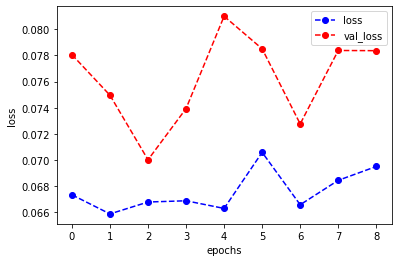

In [ ]:
plot_accuracy_loss(chennai_history)

**Plotting train & test Predictions**

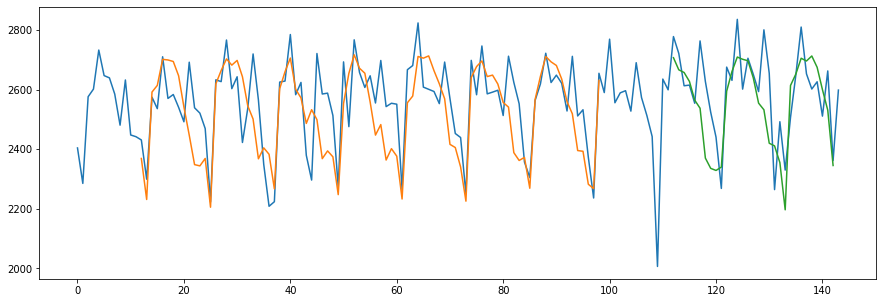

In [ ]:
look_back=12
trainPredictPlot = np.empty_like(mumbai_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = inv_train_predict

testPredictPlot = np.empty_like(df_all_r)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(mumbai_scaled)-1, :] = inv_test_predict

plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(mumbai_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [ ]:
len(test_data)

44

**Predicting Sales for Chennai region for the next 24 months**

In [ ]:
x_input=test_data[44-12:].reshape(1,-1)

temp_input=list(x_input)

temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=12
i=0
while(i<25):
    
    if(len(temp_input)>12):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} month >100 input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} month >100 output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

1 month >100 input [0.42326703 0.54249548 0.78830621 0.91946956 0.73393611 0.82423146
 0.85593731 0.65738397 0.7509343  0.26931887 0.47944545 0.37278923]
1 month >100 output [[0.33196208]]
2 month >100 input [0.54249548 0.78830621 0.91946956 0.73393611 0.82423146 0.85593731
 0.65738397 0.7509343  0.26931887 0.47944545 0.37278923 0.33196208]
2 month >100 output [[0.6530569]]
3 month >100 input [0.78830621 0.91946956 0.73393611 0.82423146 0.85593731 0.65738397
 0.7509343  0.26931887 0.47944545 0.37278923 0.33196208 0.65305692]
3 month >100 output [[0.8106046]]
4 month >100 input [0.91946956 0.73393611 0.82423146 0.85593731 0.65738397 0.7509343
 0.26931887 0.47944545 0.37278923 0.33196208 0.65305692 0.81060457]
4 month >100 output [[0.84089565]]
5 month >100 input [0.73393611 0.82423146 0.85593731 0.65738397 0.7509343  0.26931887
 0.47944545 0.37278923 0.33196208 0.65305692 0.81060457 0.84089565]
5 month >100 output [[0.80933726]]
6 month >100 input [0.82423146 0.85593731 0.65738397 0.750

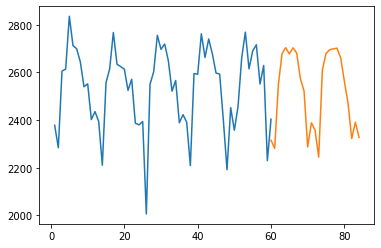

In [ ]:
month_new=np.arange(1,61)
month_pred=np.arange(60,85)

plt.plot(month_new,scaler.inverse_transform(chennai_scaled[len(chennai_scaled)-60:]))
plt.plot(month_pred,scaler.inverse_transform(lst_output))

prediction says for Chennai, for 2017 sales ranges between 2300 to 2700 & for 2018 it ranges between 2300 to 2700

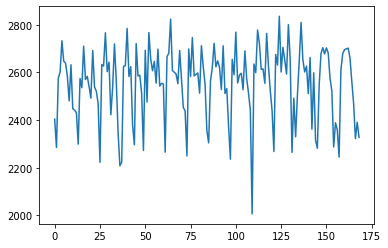

In [ ]:
df_pred=mumbai_scaled.tolist()
df_pred.extend(lst_output)
df_pred=scaler.inverse_transform(df_pred).tolist()
plt.plot(df_pred)

# **For Delhi**

In [ ]:
df_Delhi  = df_Delhi .drop(columns=['HQ', 'Country', 'City_of_outlet', 'Month', 'Day', 'Year'])
df_Delhi ['Date'] = pd.to_datetime(df_Delhi ['Date'],format='%Y%m%d')
df_Delhi ['Year'] = pd.DatetimeIndex(df_Delhi ['Date']).year
df_Delhi ['Month'] = pd.DatetimeIndex(df_Delhi ['Date']).month

df_Delhi ["Period"] = df_Delhi ["Year"].astype(str) +"-" +df_Delhi ["Month"].astype(str)

df_Delhi  = df_Delhi .groupby('Period').Total_Sales.sum().reset_index()
df_Delhi ['Period'] = pd.to_datetime(df_Delhi ['Period'],format='%Y-%m')
df_Delhi .sort_values(by=['Period'], inplace =True)

**Plotting Sales graph**

In [ ]:
plot_data = [
    go.Scatter(
        x=df_Delhi['Period'],
        y=df_Delhi['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.update_layout(yaxis_range=[45,100])
pyoff.iplot(fig)

In [ ]:
df_Delhi.set_index('Period', inplace=True)
df_Delhi.head(3)


,Total_Sales
Period,
2005-01-01,1741.6
2005-02-01,1742.8
2005-03-01,2312.2


**Scaling & spliting data into train & test in the ratio 70:30**

In [ ]:
delhi_scaled = scaler.fit_transform(np.array(df_Delhi).reshape(-1,1))

training_size = int(len(delhi_scaled)*0.70)
test_size = len(delhi_scaled)-training_size
train_data, test_data = delhi_scaled[0:training_size,:], delhi_scaled[training_size:len(delhi_scaled)+1,:1]

time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(87, 12, 1)
(31, 12, 1)


**Model Building**

In [ ]:
delhi_history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=15, batch_size=50, verbose=1)

Epoch 1/15
2/2 [==============================] - 1s 528ms/step - loss: 0.1146 - val_loss: 0.0716
Epoch 2/15
2/2 [==============================] - 1s 509ms/step - loss: 0.1053 - val_loss: 0.0550
Epoch 3/15
2/2 [==============================] - 1s 473ms/step - loss: 0.0925 - val_loss: 0.0557
Epoch 4/15
2/2 [==============================] - 1s 460ms/step - loss: 0.0912 - val_loss: 0.0861
Epoch 5/15
2/2 [==============================] - 1s 466ms/step - loss: 0.1019 - val_loss: 0.0601
Epoch 6/15
2/2 [==============================] - 1s 468ms/step - loss: 0.0867 - val_loss: 0.0571
Epoch 7/15
2/2 [==============================] - 1s 454ms/step - loss: 0.0872 - val_loss: 0.0608
Epoch 8/15
2/2 [==============================] - 1s 443ms/step - loss: 0.0921 - val_loss: 0.0667
Epoch 9/15
2/2 [==============================] - 1s 444ms/step - loss: 0.0875 - val_loss: 0.0612
Epoch 10/15
2/2 [==============================] - 1s 440ms/step - loss: 0.0823 - val_loss: 0.0588
Epoch 11/15
2/2 [==

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

mean_absolute_error(y_train,train_predict), mean_absolute_error(y_test,test_predict)

(0.08160536022100631, 0.0624953623291187)

In [ ]:
inv_train_predict=scaler.inverse_transform(train_predict)
inv_test_predict=scaler.inverse_transform(test_predict)

mean_absolute_error(y_train,inv_train_predict), mean_absolute_error(y_test,inv_test_predict)

(2290.835858454028, 2348.140183345761)

We can expect an error of 2348.14 in for predictions 

**Plotting Loss**

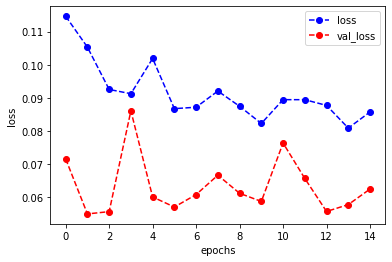

In [ ]:
plot_accuracy_loss(delhi_history)

**Plotting train & test Predictions**

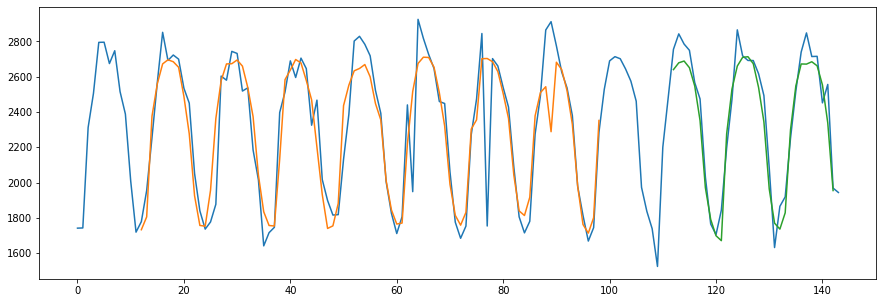

In [ ]:
look_back=12
trainPredictPlot = np.empty_like(delhi_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = inv_train_predict

testPredictPlot = np.empty_like(df_all_r)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(delhi_scaled)-1, :] = inv_test_predict

plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(delhi_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [ ]:
len(test_data)

44

**Predicting Sales for Delhi region for the next 24 months**

In [ ]:
x_input=test_data[44-12:].reshape(1,-1)

temp_input=list(x_input)

temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=12
i=0
while(i<25):
    
    if(len(temp_input)>12):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

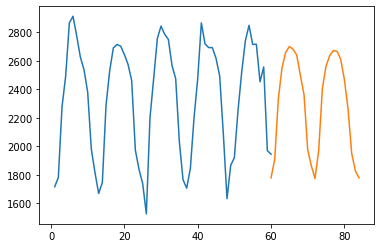

In [ ]:
plt.plot(month_new,scaler.inverse_transform(delhi_scaled[len(delhi_scaled)-60:]))
plt.plot(month_pred,scaler.inverse_transform(lst_output))

for 2017 sales ranges between 1800 -2650, for 2018 sales ranges between 1800 to 2600

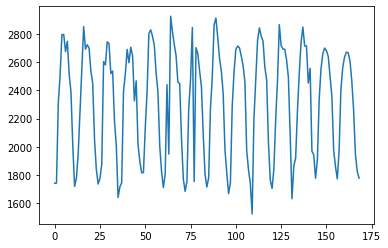

In [ ]:
df_pred=delhi_scaled.tolist()
df_pred.extend(lst_output)
df_pred=scaler.inverse_transform(df_pred).tolist()
plt.plot(df_pred)

## **For Calcutta**

In [ ]:
df_Calcutta  = df_Calcutta .drop(columns=['HQ', 'Country', 'City_of_outlet', 'Month', 'Day', 'Year'])
df_Calcutta ['Date'] = pd.to_datetime(df_Calcutta ['Date'],format='%Y%m%d')
df_Calcutta ['Year'] = pd.DatetimeIndex(df_Calcutta ['Date']).year
df_Calcutta ['Month'] = pd.DatetimeIndex(df_Calcutta ['Date']).month

df_Calcutta ["Period"] = df_Calcutta ["Year"].astype(str) +"-" +df_Calcutta ["Month"].astype(str)

df_Calcutta  = df_Calcutta .groupby('Period').Total_Sales.sum().reset_index()
df_Calcutta ['Period'] = pd.to_datetime(df_Calcutta ['Period'],format='%Y-%m')
df_Calcutta .sort_values(by=['Period'], inplace =True)


**Plotting Sales graph**

In [ ]:
plot_data = [
    go.Scatter(
        x=df_Calcutta['Period'],
        y=df_Calcutta['Total_Sales'],
        
    )
]
plot_layout = go.Layout(
        title='Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
df_Calcutta.set_index('Period', inplace=True)
df_Calcutta.head()

,Total_Sales
Period,
2005-01-01,2042.7
2005-02-01,2076.3
2005-03-01,2481.9
2005-04-01,2522.2
2005-05-01,2694.3


**Scaling & spliting data into train & test in the ratio 70:30**

In [ ]:
calcutta_scaled = scaler.fit_transform(np.array(df_Calcutta).reshape(-1,1))

training_size = int(len(calcutta_scaled)*0.70)
test_size = len(calcutta_scaled)-training_size
train_data, test_data = calcutta_scaled[0:training_size,:], calcutta_scaled[training_size:len(calcutta_scaled)+1,:1]

**Creating a window of 12 to provide info to model to predict the label**

In [ ]:
time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(87, 12, 1)
(31, 12, 1)


**Model Building**

In [ ]:
calcutta_history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=9, batch_size=50, verbose=1)

Epoch 1/9
2/2 [==============================] - 1s 492ms/step - loss: 0.0608 - val_loss: 0.0722
Epoch 2/9
2/2 [==============================] - 1s 453ms/step - loss: 0.0587 - val_loss: 0.0678
Epoch 3/9
2/2 [==============================] - 1s 451ms/step - loss: 0.0608 - val_loss: 0.0683
Epoch 4/9
2/2 [==============================] - 1s 424ms/step - loss: 0.0581 - val_loss: 0.0684
Epoch 5/9
2/2 [==============================] - 1s 445ms/step - loss: 0.0577 - val_loss: 0.0688
Epoch 6/9
2/2 [==============================] - 1s 430ms/step - loss: 0.0569 - val_loss: 0.0672
Epoch 7/9
2/2 [==============================] - 1s 433ms/step - loss: 0.0568 - val_loss: 0.0669
Epoch 8/9
2/2 [==============================] - 1s 466ms/step - loss: 0.0572 - val_loss: 0.0657
Epoch 9/9
2/2 [==============================] - 1s 448ms/step - loss: 0.0566 - val_loss: 0.0671


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

mean_absolute_error(y_train,train_predict), mean_absolute_error(y_test,test_predict)

(0.056087227062523316, 0.06707141902114709)

In [ ]:
inv_train_predict=scaler.inverse_transform(train_predict)
inv_test_predict=scaler.inverse_transform(test_predict)

mean_absolute_error(y_train,inv_train_predict), mean_absolute_error(y_test,inv_test_predict)

(2409.797754292313, 2441.3428915946993)

We can expect an error of 2441.34 in for predictions 

**Plotting Loss**

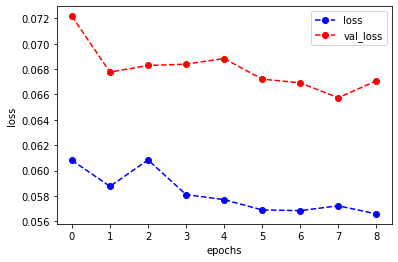

In [ ]:
plot_accuracy_loss(calcutta_history)

**Plotting train & test Predictions**

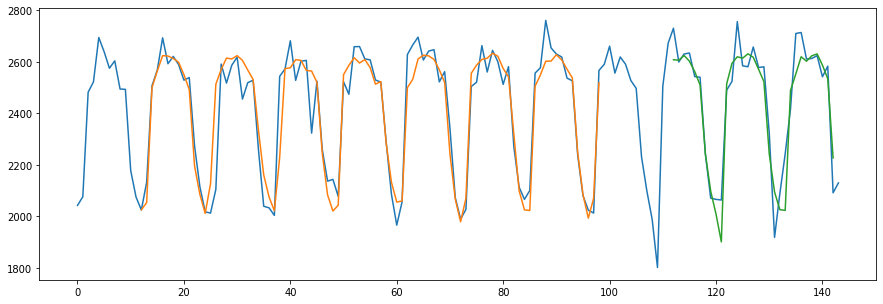

In [ ]:
look_back=12
trainPredictPlot = np.empty_like(calcutta_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = inv_train_predict

testPredictPlot = np.empty_like(df_all_r)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(calcutta_scaled)-1, :] = inv_test_predict

plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(calcutta_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

**Predicting Sales for Calcutta region for the next 24 months**

In [ ]:
x_input=test_data[44-12:].reshape(1,-1)

temp_input=list(x_input)

temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=12
i=0
while(i<25):
    
    if(len(temp_input)>12):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

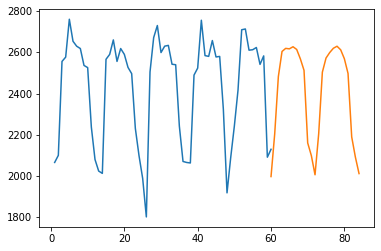

In [ ]:
plt.plot(month_new,scaler.inverse_transform(calcutta_scaled[len(calcutta_scaled)-60:]))
plt.plot(month_pred,scaler.inverse_transform(lst_output))

for 2017 sales ranges between 2000 to 2600, for 2018 sales ranges between 2000 to 2600

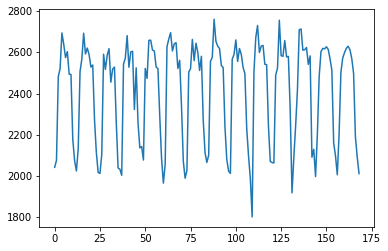

In [ ]:
df_pred=calcutta_scaled.tolist()
df_pred.extend(lst_output)
df_pred=scaler.inverse_transform(df_pred).tolist()
plt.plot(df_pred)

Analysis of each regions + all regions combined together are done 